# Twitter Gender Classification

For this project, twitter author gender classifiers are built using statistical models. 3600 Twitter posts are used to train and validate models and additional 500 posts are used for final classification using the models with superior performances. 

Prior to modelling the datasets are firstly pre-processed and features are generated using TF-IDF vectoriser. Then, five classifiers of Logistic Regression, Bernoulli Naive Bayes, Linear SVC, Random Forest and XGBoost are compared using cross validation. The top three models of Logistic Regression, Linear SVC and XGBoost are selected to be tuned.

And these optimised models are then used to make classification on the 500 test Twitter posts.

# Table of Contents

- [Import Libraries](#1)
- [Loading Datasets](#2)
- [Pre-processing Datasets](#3)
- [Statistical Models](#4)
    - [Pre-processing](#4.1)
    - [Top Words from Tweets](#4.2)
    - [Building Models](#4.3)
    - [Ensemble Statistical Models](#4.4)
    - [Vectoriser Tuning](#4.5)
    - [Hyperparameter Tuning - Logistic Regression](#4.6)
    - [Hyperparameter Tuning - Linear SVC](#4.7)
    - [Hyperparameter Tuning - XGBoost](#4.8)
- [Making Final Prediction](#5)
    - [Pre-processing Test Dataset](#5.1)
    - [Linear SVC Model](#5.2)
    - [Logistic Regression Model](#5.3)
    - [XGBoost Model](#5.4)


<a name=1></a>
## Import Libraries

In [ ]:
# Import libraries
import zipfile as zf
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import re
import seaborn as sns
import random, math
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn  import metrics
from sklearn import svm
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import stop_words

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Install nltk packages
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Install BERT
#!pip install bert-for-tf2
#!pip install sentencepiece

In [ ]:
# Import tensorflow and BERT
#try:
#    %tensorflow_version 2.x
#except Exception:
#    pass
#import tensorflow as tf
#
#import tensorflow_hub as hub
#
#from tensorflow.keras import layers
#import bert

<a name=2></a>
## Loading Datasets

In [ ]:
# Extract data from zip file
files = zf.ZipFile("data.zip", 'r')
files.extractall('./')
files.close()

In [ ]:
# Read csv
train = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')

# Convert id to list
trainId = train['id'].tolist()

# inspect id
trainId[:5]

['d7d392835f50664fc079f0f388e147a0',
 'ee40b86368137b86f51806c9f105b34b',
 '919bc742d9a22d65eab1f52b11656cab',
 '15b97a08d65f22d97ca685686510b6ae',
 'affa98421ef5c46ca7c8f246e0a134c1']

In [ ]:
# xml parsing 
# Parse xml
def parseXML(trainId):
    content = []
    
    # Encoding utf-8
    xmlp = ET.XMLParser(encoding='utf-8') 
    # Append .xml to make filename
    xml = trainId +'.xml'
    # It depends on your data location
    mytree = ET.parse('./data/'+xml,parser=xmlp)
    # Find root
    myroot = mytree.getroot()

    for x in myroot[0]:
        content.append(x.text)
    
    return content

# Save each document into list
documents = []

for trainid in trainId:
    content = parseXML(trainid)
    documents.append(' '.join(content))

# Create new column for document
train['documents'] = documents

# Inspect the number of documents is matched with trainId length
print(len(documents))
print(len(trainId))

3100
3100


<a name=3></a>
## Pre-processing Datasets

In [ ]:
np.random.seed(0)

In [ ]:
# Find the number of mentions
train['mentions'] = train['documents'].map(lambda x: len(re.findall(r'@\w+',x)))
# Find the number of hashtags
train['hashtag'] = train['documents'].map(lambda x: len(re.findall(r'#\w+',x)))
# Find the number of emojis (not accurate)
train['emoji'] = train['documents'].map(lambda x: len(re.findall('[\U00010000-\U0010ffff]', x, flags=re.UNICODE)))

# First preprocessing
train['documents_firstPre'] = train['documents']
# Convert to lowercase
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: x.lower())
# Remove https
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r'http\S+','',x))
# Convert encoding of apostrophs
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r'’',"'",x))
# Convert double quotes to single quotes
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r'"',"'",x))
# Expand apostrophes contraction (ex. he's > he is)
contract = ['can\'t','doesn\'t','don\'t','didn\'t','isn\'t','aren\'t','won\'t','wasn\'t','weren\'t','gonna','hasn\'t','haven\'t',\
            'hadn\'t','they\'ll','they\'ve','he\'ll','she\'ll','i\'m','i\'ll','i\'ve','we\'ll','we\'ve',\
            'i\'d','he\'d','she\'d','they\'d','we\'d','it\'d']
expand = ['can not','does not','do not','did not','is not','are not','will not','was not','were not','going to','has not','have not',\
          'had not','they will','they have','he will','she will','i am','i will','i have','we will','we have',\
          'i would','he would','she would','they would','we would','it would']
apo_dic = dict(zip(contract,expand))
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: x.split())
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: \
                        [apo_dic[word] if '{}'.format(word)  in apo_dic else '{}'.format(word) for word in x])
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: ' '.join(x))
# Convert emoji to text
emoji_li = list()
text_li = list()
for sen in train['documents_firstPre']:
    for word in sen:
        try:
            # If emoji, add emoji and its meaning to lists
            if UNICODE_EMOJI[word]: 
                emoji_li.append(word)
                text_li.append(UNICODE_EMOJI[word])
        except:
            pass
emoji_dict = dict(zip(emoji_li, text_li))
#train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: \
#                [emoji_dict[word] if word in emoji_dict else word for word in x])
#train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: "".join(x))
# Remove mentions
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r'@\w+','',x))
# Remove hashtags
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r'#\w+','',x))
# Remove punctuations and numbers
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub('[^a-zA-Z]',' ',x))
# Remove single character
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub(r"\s+[a-zA-Z]\s+",' ',x))
# Remove untransformed emoji
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x: re.sub('[\U00010000-\U0010ffff]', '', x))
# Remove new line characters
train['documents_firstPre'] = train['documents_firstPre'].map(lambda x:re.sub('\s+', ' ',x))

# Convert to list
firstDocument = train['documents_firstPre'].tolist()
# Copy dataframe
df_train = train.copy()

<a name=4></a>
## Statistical Models



<a name=4.1></a>
### Pre-processing

In [ ]:
# Retrieve list of tweets and genders 
trainDocs = train.documents_firstPre.tolist()  # pre-processed
gender = train.gender.tolist()

In [ ]:
# Get the stop words list from nltk.corpus
addition = ['amp','just','like','wa','ha']
stop = list(stopwords.words('english'))
stop_sk = list(stop_words.ENGLISH_STOP_WORDS)
stop_sk = stop_sk + addition + stop


# Define tweet_tokenizer
tweet_tokenizer = TweetTokenizer()

# Define LemmaTokenizer to help vectorize the text
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in tweet_tokenizer.tokenize(doc)]

In [ ]:
# Define function to show top frequent words
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(
        analyzer='word',input='content',
        lowercase=True, # convert to lowercase
        token_pattern='(?u)\\b\\w\\w+\\b',
        min_df=3,
        ngram_range=(1,3),
        tokenizer=LemmaTokenizer(), 
        stop_words = set(stop_sk)
    ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# Split training data into train and test sets
seed = 7
test_size = 0.2
x_train, x_valid, y_train, y_valid = train_test_split(trainDocs,gender, test_size=test_size, random_state=seed)

<a name=4.2></a>
### Top Words from Tweets

/Users/jay/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


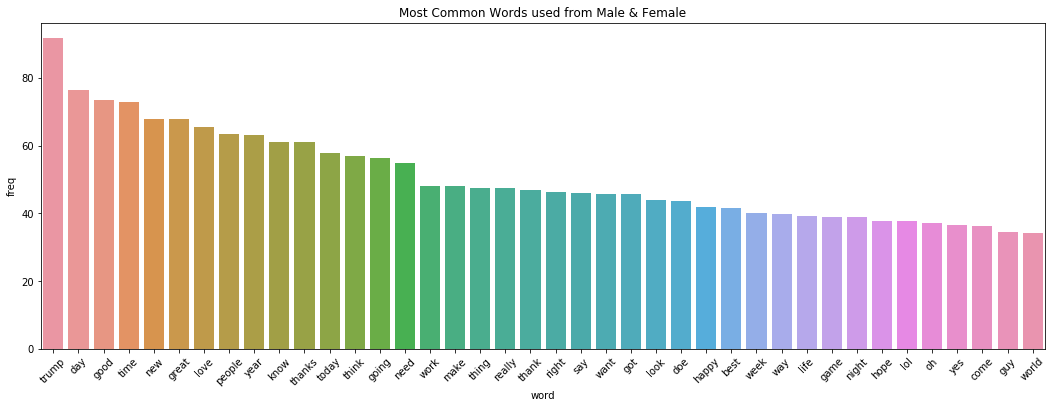

In [ ]:
# Top 40 words from both genders
both_top_words = get_top_n_words(trainDocs, 40)

# Plot top words
fig = plt.figure(figsize=(18,6))
df_topwords = pd.DataFrame(both_top_words, columns = ['word','freq'])
sns.barplot(x=df_topwords.word, y=df_topwords.freq)
plt.title('Most Common Words used from Male & Female')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Divide training dataset by gender
df_doc_gender = pd.DataFrame({'doc':trainDocs, 'gender':gender})
df_doc_male = df_doc_gender.loc[df_doc_gender.gender == 'male']
df_doc_female = df_doc_gender.loc[df_doc_gender.gender == 'female']

/Users/jay/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


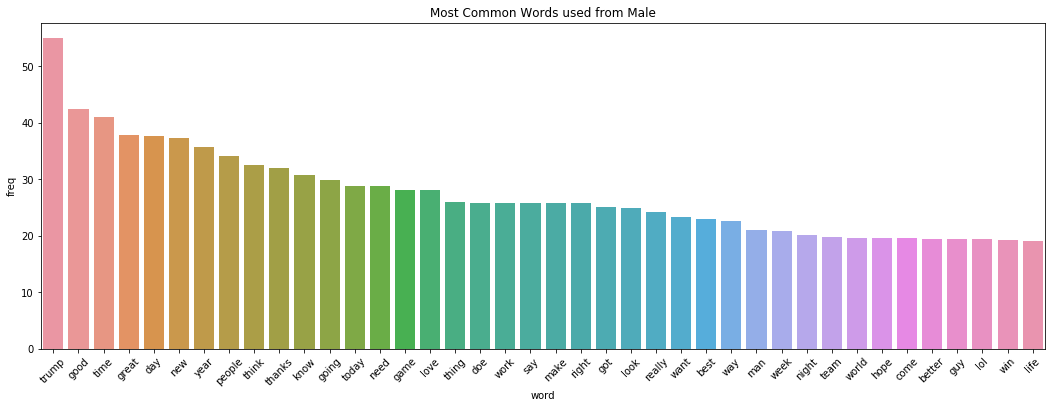

In [ ]:
# Top 40 words from male
male_top_words = get_top_n_words(df_doc_male.doc, 40)

# Plot top words
fig = plt.figure(figsize=(18,6))
df_topwords = pd.DataFrame(male_top_words, columns = ['word','freq'])
sns.barplot(x=df_topwords.word, y=df_topwords.freq)
plt.title('Most Common Words used from Male')
plt.xticks(rotation=45)
plt.show()

/Users/jay/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


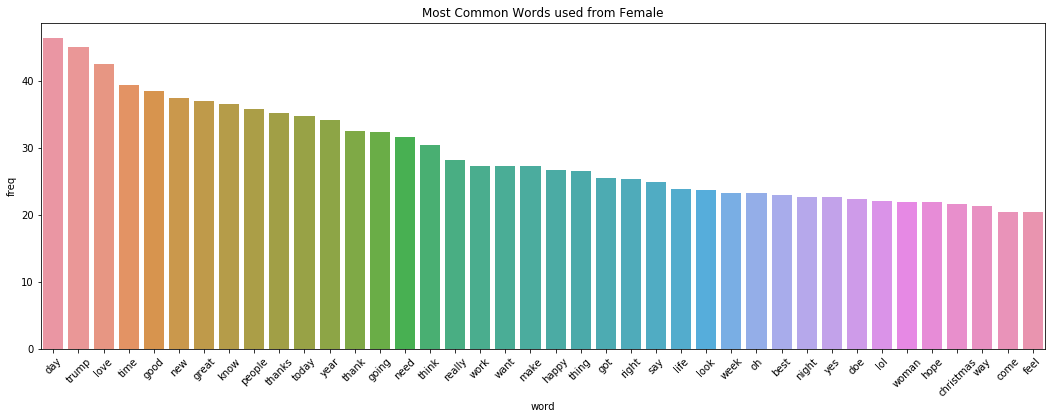

In [ ]:
# Top 40 words from female
female_top_words = get_top_n_words(df_doc_female.doc, 40)

# Plot top words
fig = plt.figure(figsize=(18,6))
df_topwords = pd.DataFrame(female_top_words, columns = ['word','freq'])
sns.barplot(x=df_topwords.word, y=df_topwords.freq)
plt.title('Most Common Words used from Female')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Set TF-IDF vectorizer
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True, # convert to lowercase
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,3), # create unigram, bigram and trigram
                           tokenizer=LemmaTokenizer(), # tokenize words
                           stop_words = set(stop_sk)) # remove stopwords

In [ ]:
# Vectorize document and gender
train=vectorizer.fit_transform(x_train)
valid=vectorizer.transform(x_valid)
gender_train=np.asarray(y_train)
gender_valid=np.asarray(y_valid)

/Users/jay/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<a name=4.3></a>
### Building Models

In [ ]:
# # Make a func to develop model for each class
# def accuracyModel(models, x_train, y_train, cv_fold): 
#     df = pd.DataFrame(index=range(cv_fold * len(models)))
#     entries = []
#     for model in models:
        
#         model_name = model.__class__.__name__

#         model.fit(x_train, gender_train)
        
#         y_predict = model.predict(x_train)
        
#         accuracies = cross_val_score(model, x_train, gender_train, scoring='accuracy', cv=cv_fold)
        
#         for fold_idx, accuracy in enumerate(accuracies):
#             entries.append((model_name, fold_idx, accuracy, y_predict))
    
#     df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'prediction'])
    
#     return df

In [ ]:
# # Train models
# models = [LogisticRegression(), BernoulliNB(), LinearSVC(), 
#           ensemble.RandomForestClassifier(), xgboost.XGBClassifier()]

# cv_fold = 5 
# trainAcc = accuracyModel(models, train, gender_train, cv_fold)

# # Draw the variation of accuracies using boxplot
# sns.boxplot(x='accuracy',y = 'model_name', data=trainAcc).set_title('Accuracy with preprocessing')
# plt.show()

In [ ]:
# # Show confusion matrix & accuracy of average cv results
# pred_li = []
# idx = 0
# for i in range(len(models)):
#     # Model name
#     modelName = trainAcc.iloc[:,0].unique()[i]

#     # Average CV accuracy
#     avg_accuracy = sum(trainAcc.iloc[idx:idx+cv_fold,2].to_list())/cv_fold
    
#     idx += cv_fold
    
#     # Validate with valid dataset
#     model = models[i]
#     model.fit(train,gender_train)
#     y_predict = model.predict(valid)

#     valid_accuracy = accuracy_score(y_predict,gender_valid) 
    
#     # Save prediction 
#     pred_li.append(y_predict)

#     # Display average results
#     print(model)
#     print(confusion_matrix(gender_valid, y_predict))
#     print(f'Average CV Accuracy: {"%.2f" % avg_accuracy}')
#     print(f'Validation Accuracy: {"%.2f" % valid_accuracy}\n')

<a name=4.4></a>
### Ensemble Statistical Models


#### Ensmeble of All Models

In [ ]:
# # Ensemble of all models
# mode_predict = np.array([])
# for i in range(len(pred_li[0])):
#     pred1 = pred_li[0]
#     pred2 = pred_li[1]
#     pred3 = pred_li[2]
#     pred4 = pred_li[3]
#     pred5 = pred_li[4]
#     mode_predict = np.append(mode_predict, max([pred1[i],pred2[i],pred3[i],pred4[i],pred5[i]]))

# # Accuracy
# accuracy = metrics.accuracy_score(gender_valid, mode_predict)
                                  
# # Display results
# print(f'Ensembled accuracy {"%.2f" % accuracy}')                                
# print(confusion_matrix(gender_valid, mode_predict))

#### Ensemble of Logistic Regression, Linear SVC, XGBoost

In [ ]:
# # Ensemble of linear svc, xgboost
# mode_predict = np.array([])
# for i in range(len(pred_li[0])):
#     pred1 = pred_li[0]
#     pred3 = pred_li[2]
#     pred5 = pred_li[4]
#     mode_predict = np.append(mode_predict, max([pred1[i],pred3[i],pred5[i]]))

# # Accuracy
# accuracy = metrics.accuracy_score(gender_valid, mode_predict)
                                  
# # Display results
# print(f'Ensembled accuracy {"%.2f" % accuracy}')                                
# print(confusion_matrix(gender_valid, mode_predict))

#### Ensemble of Linear SVC, XGBoost

In [ ]:
# # Ensemble of linear svc, xgboost
# mode_predict = np.array([])
# for i in range(len(pred_li[0])):
#     pred1 = pred_li[0]
#     pred3 = pred_li[2]
#     pred5 = pred_li[4]
#     mode_predict = np.append(mode_predict, max([pred3[i],pred5[i]]))

# # Accuracy
# accuracy = metrics.accuracy_score(gender_valid, mode_predict)
                                  
# # Display results
# print(f'Ensembled accuracy {"%.2f" % accuracy}')                                
# print(confusion_matrix(gender_valid, mode_predict))

<a name=4.5></a>
### Vectoriser Tuning


#### Optimise Max_df

In [ ]:
# # Define gender as array
# gender_train=np.asarray(y_train)

# pipe = make_pipeline(TfidfVectorizer(analyzer='word',input='content',
#                            lowercase=True, # convert to lowercase
#                            token_pattern='(?u)\\b\\w\\w+\\b',
#                            min_df=3,
#                            ngram_range=(1,3), # create unigram, bigram and trigram
#                            tokenizer=LemmaTokenizer(), # tokenize words
#                            stop_words = set(stop_sk))
#                      , LinearSVC())

# param_grid = {"tfidfvectorizer__max_df":[0.5,0.6,0.7,0.8,0.9]}

# grid = GridSearchCV(pipe, param_grid, cv=5)
# grid.fit(x_train,gender_train)

In [ ]:
# # Return test result
# scores = grid.cv_results_['mean_test_score'].reshape(-1,5).T
# scores

Max_df not to be altered due to insignificant improvement.


#### Optimise Min_df

In [ ]:
# # Define gender as array
# gender_train=np.asarray(y_train)

# pipe = make_pipeline(TfidfVectorizer(analyzer='word',input='content',
#                            lowercase=True, # convert to lowercase
#                            token_pattern='(?u)\\b\\w\\w+\\b',
#                            max_df=0.9,
#                            ngram_range=(1,3), # create unigram, bigram and trigram
#                            tokenizer=LemmaTokenizer(), # tokenize words
#                            stop_words = set(stop_sk))
#                      , LinearSVC())

# param_grid = {"tfidfvectorizer__min_df":[3,4,5,0.1,0.15,0.2]}

# grid = GridSearchCV(pipe, param_grid, cv=5)
# grid.fit(x_train,gender_train)

In [ ]:
# # Return test result
# scores = grid.cv_results_['mean_test_score'].reshape(-1,6).T
# scores

Min_df not to be altered due to insignificant improvement. 

<a name=4.6></a>
### Hyperparameter Tuning - Logistic Regression

In [ ]:
# # Determine optimised C and penalty
# param_grid = {'C':[0.1,1,10,100,1000], 'penalty':['l1','l2']}

# grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 5)

# grid.fit(train, gender_train)

In [ ]:
# # Display results
# print(grid.best_params_)
# print(grid.best_estimator_)

#### Test Optimised Model

In [ ]:
# #### Test Optimised Model
# # Define optimised model
# lr_model = LogisticRegression(C=10,penalty='l2')

# lr_model.fit(train, gender_train)
# y_predict = lr_model.predict(valid)
# valid_accuracy = accuracy_score(y_predict,gender_valid) 

# # Display results
# print(f'Optimised Logistic Regression accuracy: {"%.2f" % valid_accuracy}')

<a name=4.7></a>
### Hyperparameter Tuning - Linear SVC

In [ ]:
# # Determine optimised C and loss
# param_grid = {'C':[0.1,1,10,100,1000], 'loss':['hinge','squared_hinge']}

# grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 5)

# grid.fit(train, gender_train)

In [ ]:
# # Display results
# print(grid.best_params_)
# print(grid.best_estimator_)

Optimised hyperparameters are identical to the default setting, hence, the model is not further tested.

<a name=4.8></a>
### Hyperparameter Tuning - XGBoost

#### Optimise Number of Boosting Iterations

In [ ]:
# # Define function to determine optimised boosting iteration numbers
# def modelfit(alg, x_train, y_train, cv_folds=5, early_stopping_rounds=10):
    
#     # Run cross validation to determine boosting iteration results
#     xgb_param = alg.get_xgb_params()
#     xgtrain = xgb.DMatrix(x_train, label=pd.factorize(gender_train)[0])
#     cvresult = xgb.cv(dtrain=xgtrain, params=xgb_param, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#         metrics='auc', early_stopping_rounds=early_stopping_rounds, as_pandas=True, verbose_eval=True)
#     alg.set_params(n_estimators=cvresult.shape[0])

#     # Fit model using optimised iteration numbers
#     alg.fit(x_train, y_train,eval_metric='auc')
        
#     # Print model report
#     print ('\nModel Report')
#     print(cvresult)
#     print(f'Optimised Number of Iterations: {cvresult.shape[0]}')

In [ ]:
# # Define initial hyperparameters
# model = XGBClassifier(
#     learning_rate =0.1,
#     n_estimators=500,
#     max_depth=5,
#     min_child_weight=1,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)

# # Determine optimised iteration numbers
# modelfit(model, train, gender_train)

# # Display results
# print('Optimised Boosting Iteration Number: 193')

#### Optimise XGBoost Tree Parameters

In [ ]:
# # Determine optimised max. depth and min. child weight
# param_test = {
#  'max_depth':range(3,5),
#  'min_child_weight':range(1,3)
# }
# grid = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=3)
# grid.fit(train, gender_train)

# print('Optimised Parameters:')
# print(grid.best_params_)

# # Display results
# print('Optimised max_depth: 4\nOptimised min_child_weight: 1')

#### Optimise Regularisation Parameters

In [ ]:
# # Determine optimised regularisation alpha
# param_test = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# grid = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=4,
#  min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=3)
# grid.fit(train, gender_train)

# print('Optimised Parameters:')
# print(grid.best_params_)

# # Display results
# print('Optimised reg_alpha: 1e-05')

#### Reduce Learning Rate & Reoptimise Number of Boosting Iterations


In [ ]:
# # Redefine learning rate
# model = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=4,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  reg_alpha=0.00001,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

# modelfit(model, train, gender_train, early_stopping_rounds=50)

# # Display results
# print('Optimised Boosting Iteration Numbers: 1000')

The number of boosting iteration is not increased beyond 1000 to limit the computational requirement of the model. 

#### Test  Optimised Model

In [ ]:
# # Define optimised model
# xgb_model = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=4,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  reg_alpha=0.00001,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

# xgb_model.fit(train, gender_train)
# y_predict = xgb_model.predict(valid)
# valid_accuracy = accuracy_score(y_predict,gender_valid) 

# # Display results
# print(f'Optimised XGBoost accuracy: {"%.2f" % valid_accuracy}')

<a name=5></a>
## Making Final Prediction

<a name=5.1></a>
### Pre-processing Test Dataset

In [ ]:
# Read csv
test = pd.read_csv('test.csv')
# Convert id to list
testId = test['id'].tolist()

In [ ]:
# Parse xml
def parseXML(trainId):
    content = []
    
    # Encoding utf-8
    xmlp = ET.XMLParser(encoding='utf-8') 
    # Append .xml to make filename
    xml = trainId +'.xml'
    # It depends on your data location
    mytree = ET.parse('./data/'+xml,parser=xmlp)
    # Find root
    myroot = mytree.getroot()

    for x in myroot[0]:
        content.append(x.text)
    
    return content

# Save each document into list
documents = []

for testid in testId:
    content = parseXML(testid)
    documents.append(' '.join(content))

# Create new column for document
test['documents'] = documents

# Inspect the number of documents is matched with trainId length
print(len(documents))
print(len(testId))

500
500


In [ ]:
# First preprocessing
test['documents_firstPre'] = test['documents']
# Convert to lowercase
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: x.lower())
# Remove https
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r'http\S+','',x))
# Convert encoding of apostrophs
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r'’',"'",x))
# Convert double quotes to single quotes
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r'"',"'",x))
# Expand apostrophes contraction (ex. he's > he is)
contract = ['can\'t','doesn\'t','don\'t','didn\'t','isn\'t','aren\'t','won\'t','wasn\'t','weren\'t','gonna','hasn\'t','haven\'t',\
            'hadn\'t','they\'ll','they\'ve','he\'ll','she\'ll','i\'m','i\'ll','i\'ve','we\'ll','we\'ve',\
            'i\'d','he\'d','she\'d','they\'d','we\'d','it\'d']
expand = ['can not','does not','do not','did not','is not','are not','will not','was not','were not','going to','has not','have not',\
          'had not','they will','they have','he will','she will','i am','i will','i have','we will','we have',\
          'i would','he would','she would','they would','we would','it would']
apo_dic = dict(zip(contract,expand))
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: x.split())
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: \
                        [apo_dic[word] if '{}'.format(word)  in apo_dic else '{}'.format(word) for word in x])
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: ' '.join(x))
# Convert emoji to text
emoji_li = list()
text_li = list()
for sen in test['documents_firstPre']:
    for word in sen:
        try:
            # If emoji, add emoji and its meaning to lists
            if UNICODE_EMOJI[word]: 
                emoji_li.append(word)
                text_li.append(UNICODE_EMOJI[word])
        except:
            pass
emoji_dict = dict(zip(emoji_li, text_li))
#test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: \
#                [emoji_dict[word] if word in emoji_dict else word for word in x])
#test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: "".join(x))
# Remove mentions
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r'@\w+','',x))
# Remove hashtags
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r'#\w+','',x))
# Remove punctuations and numbers
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub('[^a-zA-Z]',' ',x))
# Remove single character
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub(r"\s+[a-zA-Z]\s+",' ',x))
# Remove emoji
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x: re.sub('[\U00010000-\U0010ffff]', '', x))
# Remove new line characters
test['documents_firstPre'] = test['documents_firstPre'].map(lambda x:re.sub('\s+', ' ',x))
# Convert to list
firstDocument = test['documents_firstPre'].tolist()

In [ ]:
# Convert to list
testDocs = test.documents_firstPre.tolist()  # pre-processed

In [ ]:
# Set TF-IDF vectorizer
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True, # convert to lowercase
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,3), # create unigram, bigram and trigram
                           tokenizer=LemmaTokenizer(), # tokenize words
                           stop_words = set(stop_sk)) # remove stopwords

In [ ]:
# Vectorize document
# Whole train dataset is used to fit transform 
train=vectorizer.fit_transform(trainDocs)
gender_train=np.asarray(gender)
test=vectorizer.transform(testDocs)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# Import final test data for checking 3 models
test_labels = pd.read_csv('test_labels.csv')

# Vectorize
gender_test = np.asarray(test_labels['gender'])

<a name=5.2></a>
### Linear SVC Model 

In [ ]:
# Define linear SVC model
linear_model = LinearSVC()

In [ ]:
# Train model on whole train dataset
linear_model.fit(train, gender_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
# Make prediction 
y_predict = linear_model.predict(test)

In [ ]:
# Measure validation testing accuracy
print(confusion_matrix(gender_test,y_predict))
recall=recall_score(gender_test,y_predict,average='macro')
precision=precision_score(gender_test,y_predict,average='macro')
f1score=f1_score(gender_test,y_predict,average='macro')
accuracy=accuracy_score(gender_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

[[214  38]
 [ 55 193]]
Accuracy: 0.814
Macro Precision: 0.8155184344775424
Macro Recall: 0.813716077828981
Macro F1 score:0.8136713162017799


<a name=5.3></a>
### Logistic Regression Model

In [ ]:
# Define linear SVC model
logis_model = LogisticRegression()

In [ ]:
# Train model on whole train dataset
logis_model.fit(train, gender_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make prediction 
y_predict = logis_model.predict(test)

In [ ]:
# Measure final testing accuracy
print(confusion_matrix(gender_test,y_predict))
recall=recall_score(gender_test,y_predict,average='macro')
precision=precision_score(gender_test,y_predict,average='macro')
f1score=f1_score(gender_test,y_predict,average='macro')
accuracy=accuracy_score(gender_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

[[203  49]
 [ 43 205]]
Accuracy: 0.816
Macro Precision: 0.8161449331028743
Macro Recall: 0.816084229390681
Macro F1 score:0.8159970559528953


In [ ]:
# One-hot encode the predictions (1: male, 2: female)
y_predict = pd.factorize(y_predict, sort=True)[0]

In [ ]:
# Create a dataframe with id and prediction
df = pd.DataFrame({'id' : testId, 'gender' : y_predict})

In [ ]:
# Save Logistic Regression prediction as final submission file
df.to_csv("pred_labels.csv", index=False)

<a name=5.4></a>
### XGBoost Model

In [ ]:
# Define linear SVC model
xg_model = xgboost.XGBClassifier()

In [ ]:
# Train model on whole train dataset
xg_model.fit(train, gender_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Make prediction 
y_predict = xg_model.predict(test)

In [ ]:
# Measure final testing accuracy
print(confusion_matrix(gender_test,y_predict))
recall=recall_score(gender_test,y_predict,average='macro')
precision=precision_score(gender_test,y_predict,average='macro')
f1score=f1_score(gender_test,y_predict,average='macro')
accuracy=accuracy_score(gender_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

[[185  67]
 [ 59 189]]
Accuracy: 0.748
Macro Precision: 0.7482389856557377
Macro Recall: 0.7481118791602662
Macro F1 score:0.7479838709677419
